# Utilization of the PostgreSQL Database

**Author**: Aurelie  
*Date Created*: 2019-07-12  
*Date Last Updated* 2019-07-23  
**Kernel/Programming Language**: R

## 1. Database Schema  


The database schema provides information on the structure of the database:
* Tables and relationships between them,
* Constraints (primary keys, foreign keys, unicity, check, etc).

The database was created around the **codes** tables (in red) and structured as follow:  
* the *blue tables* contain all the information collected by the field team,
* the *green* and *purple tables* contain all the information used to check for data quality using a primary/foreign key system. 
* the *green* tables contain all the information used to generate and read the barcodes.
* the *blue text* describes the unicity constraints within each table. These were established to ensure that data were entered only once within the database.

## 2. Data Dictionary

The [data dictionary](https://docs.google.com/spreadsheets/d/153k7tV7lnRZBif4l0WK_0UYk9ZOjL6RaKAPTs9_Biu8/edit#gid=0) provides a description of all the variables within the database. Information was provided by table (ordered alphabetically). For each table, the following information was summarized:
* a list of all columns,
* their respective data types,
* their respective units (if applicable),
* and a short description of what each variable/parameter is.

## 3. Connect to PostgreSQL Database.

The first step is to connect to database. Credentials were provided in the data dictionary.  
I created the following function to connect to our database using R:

In [216]:
ConnectToDB <- function(){ # begin ConnectToDB() function

  # import required package
  require(RPostgres)

  # creates a connection to the postgres database
  con <- dbConnect(Postgres(),
                   dbname = "crowndb",
                   host = "crownproject.postgres.database.usgovcloudapi.net",
                   port = 5432,
                   user = "CROWNadmin@crownproject",
                   password = "****************",
                   sslmode = "require")

    return(con)

} # end ConnectToDB() function

Good coding practices require **NOT** including your credentials in your notebook (or any file to be shared or going into GitHub).  Therefore, I created this function in a separate script and saved it locally on my desktop. Running this script requires to install the *RPostgres* package.

Then, I connect to PostgreSQL as follow:

In [217]:
source("~/Desktop/configuration.R") # read external file
con <- ConnectToDB() # connect to database

## 4. Retrieve Data from PostgreSQL Database and Data Visualization.

Once connected to the database, you can retrieve data using SQL.  
In R, data are being retrieved from the database using the *dbGetQuery* function.

### **Example 1:** Map All Experimental Sites Represented in the Database.

The first step is to select the site information available for all on-farm trials. 
This information is provided in the *site_information* table.
To select all columns, use *'*'* after *SELECT*.

In [218]:
query1 <- "SELECT * FROM site_information" # Define SQL query
data1 <- as.data.frame(dbGetQuery(con, query1)) # Execute SQL query, and save results into a table
# head(data1,3) # don't forget to check data import!

This code stores the retrieved data into a dataframe, which can be used for data visualization and analysis.

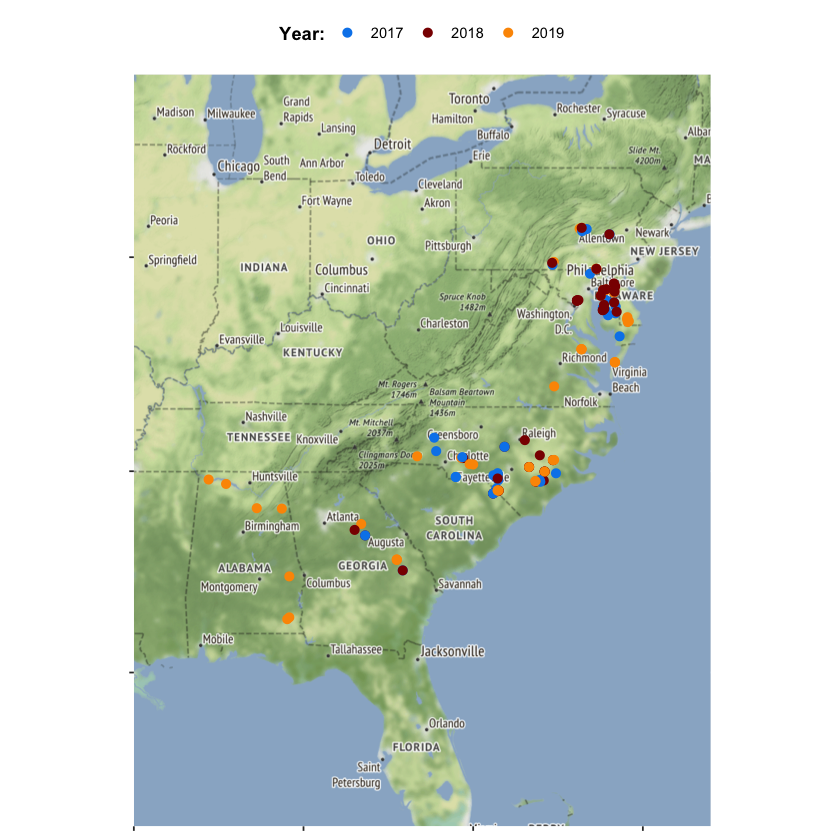

In [219]:
require(ggmap) # import required packages
map <- get_map(location = c(left = -90, bottom = 26, right = -73, top = 44)) # get map of the Eastern US.

# Plot sites on map
ggmap(map) +  # create map

geom_point(data=data1[is.na(data1$longitude) == F & is.na(data1$latitude) == F,], 
           aes(x = longitude, y = latitude, color=year), shape=16, size=2.5)+ # add sites

scale_color_manual(values=c("#0086EC","darkred","#FC9700"),name="Year:")+ # select desired colors

theme(legend.position="top",  legend.title=element_text(face="bold"), legend.key = element_rect(fill=NA), 
      axis.title = element_blank(), axis.text = element_blank()) # format plot


### **Example 2:** Characterize the Soil Texture of the 2017-2018 North Carolina Sites on the USDA Soil Texture Triangle.

In the first example, data were retrieved using a very simple SQL query.
This second example will show how to build more complicated SQL queries using *JOIN* and *WHERE* statements.
Let's retrieve the *code*, *depth*, *subplot*, *sand*, and *silt* information from the *texture* table for all North Carolina sites. Let's focus only on the 2017 and 2018 growing seasons.

In [220]:
query2 <- "SELECT texture.code, depth, subplot, sand, silt, year, state, latitude, longitude FROM texture
            LEFT JOIN site_information ON texture.code = site_information.code
            WHERE (site_information.year = '2017' OR site_information.year = '2018') AND state = 'NC'" # define SQL query

data2 <- as.data.frame(dbGetQuery(con, query2)) # Execute SQL query, and save results into a table


Let's calculate clay content from the *sand* and *silt* columns. We call that columns *clay*.

In [221]:
data2 <- within(data2, clay <- 100 - sand - silt) # calculate clay content and name the column clay.

Let's not forget to make sure that the data imported correctly:

In [222]:
# head(data2,3) # Show the first 3 rows of the table
print(paste("All years in data2:",paste(unique(data2$year),collapse=" "), collapse=" "))
print(paste("All states in data2:",paste(unique(data2$state),collapse=" "), collapse=" "))

[1] "All years in data2: 2017 2018"
[1] "All states in data2: NC"


Now, let's plot the data on the USDA soil texture triangle.

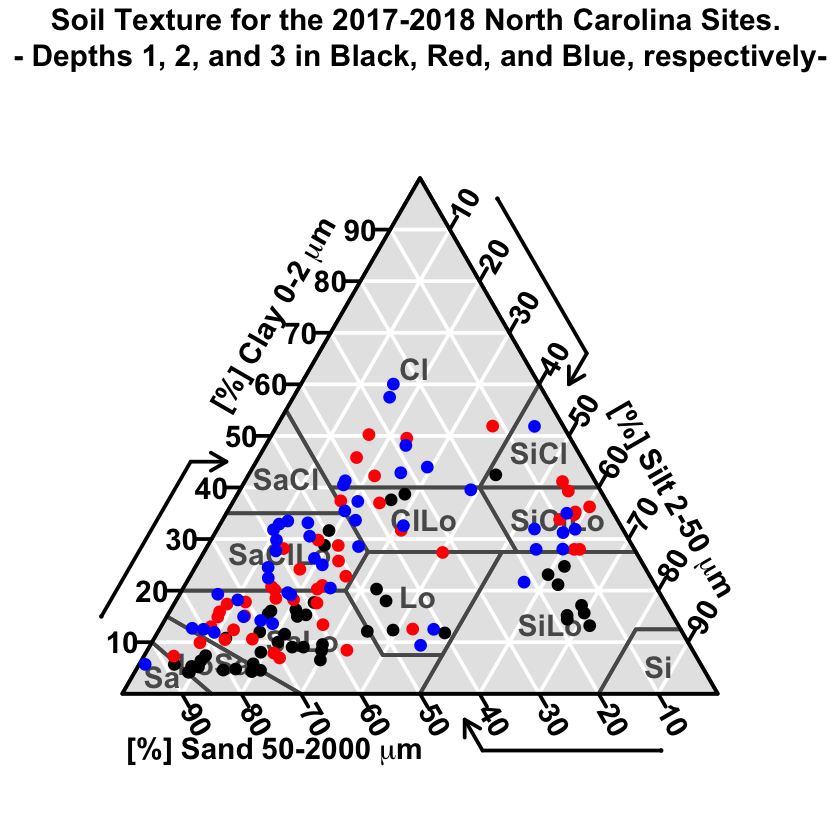

In [223]:
require(soiltexture) # import required packages

# format data for plotting
data.d1<-na.omit(data2[data2$depth == 1 ,c("sand","silt","clay")]); colnames(data.d1)<-c("SAND","SILT","CLAY") # depth 1
data.d2<-na.omit(data2[data2$depth == 2,c("sand","silt","clay")]); colnames(data.d2)<-c("SAND","SILT","CLAY")
data.d3<-na.omit(data2[data2$depth == 3,c("sand","silt","clay")]); colnames(data.d3)<-c("SAND","SILT","CLAY")

# Plot Data on Textural Triangle
geo <- TT.geo.get()
TT.plot(class.sys = "USDA.TT", tri.data=data.d1, pch=20,col="black", main = "Soil Texture for the 2017-2018 North Carolina Sites. 
- Depths 1, 2, and 3 in Black, Red, and Blue, respectively-") # depth 1
TT.points(tri.data = data.d2, geo = geo, pch=20, col="red") # depth 2
TT.points(tri.data = data.d3, geo = geo, pch=20, col="blue") # depth 3

### **Example 3:** Select *code*, *treatment*, *subplot*, *row*, and *harvest_wt* from the *yield* table for all the sites in NC.

It is also possible to combine SQL and R code to execute even more complicated queries.
Let's retrieve the *code*, *treatment*, *subplot*, *row*, and *harvest_wt* from the *yield* table for all the sites that were represented on the textural triangle for example 2.

In [224]:
query3 <- paste("SELECT code, treatment, subplot, row, harvest_wt FROM yield WHERE code IN ('",
               paste(unique(data2$code),collapse="','"),"')",sep="") # define SQL query
data3 <- as.data.frame(dbGetQuery(con, query3)) # Execute SQL query, and save results into a table

Always makes sure that the data were imported properly!!!

In [225]:
# head(data3, 3) # Always make sure to check data import !!!
paste("Value is TRUE is all codes present in data3 were present in data2: value =", all(unique(data3$code) %in% unique(data2$code) == T))

[1] "Value is TRUE is all codes present in data3 were present in data2: value = TRUE"

Now, let's format and visualize the data.

**Data Formating**

In [226]:
# import required libraries
library(tidyr)

# average the data by code and treatment.
data.plot <- aggregate(list(data3$harvest_wt),list(data3$code, data3$treatment), mean, na.rm=T)
colnames(data.plot) <- c("code", "treatment", "harvest_wt")
# head(data.plot) # make sure the data were averagesd properly

# convert data from long to wide
data.plot.wide <- spread(data.plot, treatment, harvest_wt) 
colnames(data.plot.wide) <- c("code", "harvest_wt_B","harvest_wt_C")
# head(data.plot.wide) # make sure that the data was reorganized properly

**Data Visualization**

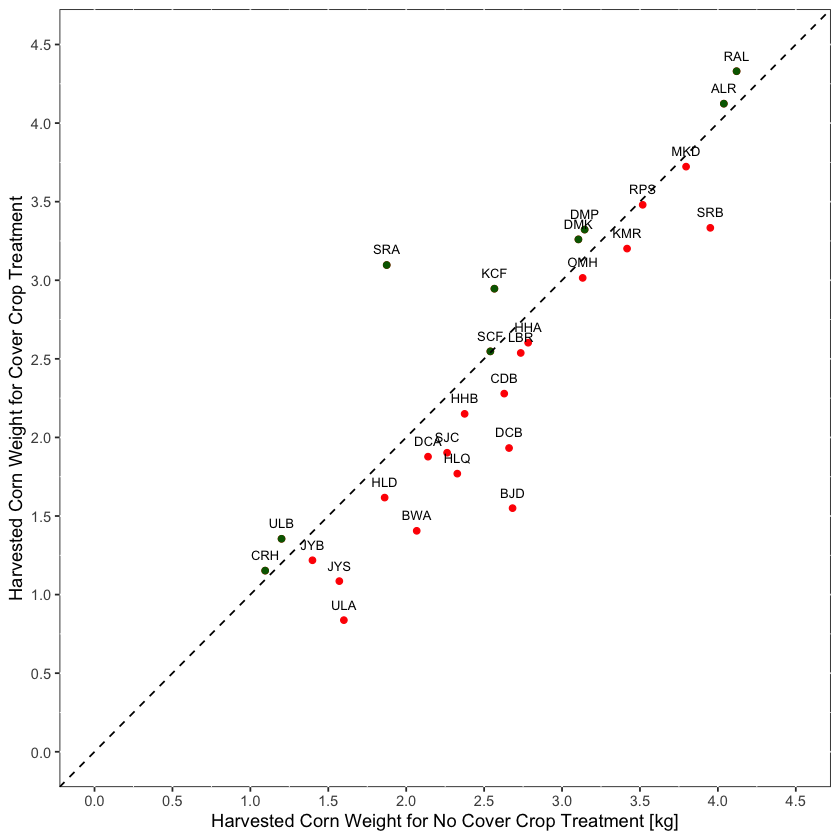

In [227]:
# create a scatterplot to compare the cover crop and no cover crop treatment cash crop yield performance.
# points
ggplot(data=data.plot.wide, aes(x=harvest_wt_B, y=harvest_wt_C))+
geom_point(color="red")+
geom_point(data=subset(data.plot.wide, harvest_wt_C>= harvest_wt_B), color="darkgreen")+
xlab("Harvested Corn Weight for No Cover Crop Treatment [kg]")+
ylab("Harvested Corn Weight for Cover Crop Treatment")+
scale_x_continuous(limits=c(0,4.5), breaks = seq(0,4.5,by=0.5))+
scale_y_continuous(limits=c(0,4.5), breaks = seq(0,4.5,by=0.5))+
geom_abline(aes(slope=1, intercept=0), linetype = "dashed",  size=0.5)+
geom_text(aes(label=code, y = harvest_wt_C + 0.1), size=2.75)+
theme(panel.background = element_rect(fill=NA, color="grey15"))